<a href="https://colab.research.google.com/github/Mingrui-Wang/FYP/blob/master/Simple_LSTM_non_outlier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import os
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive/FYP数据集/"
os.chdir(path)
os.listdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['Line_100_day.csv', 'Line_100_day_winsorize.csv']

In [36]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
%matplotlib inline

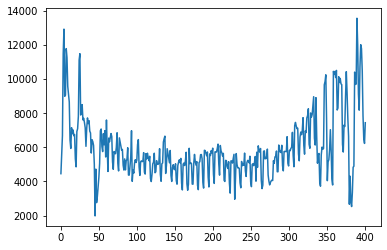

In [37]:
# load the dataset
dataframe = read_csv('Line_100_day_winsorize.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
# 将整型变为float
dataset = dataset.astype('float32')

plt.plot(dataset)
plt.show()

In [38]:
# X is the number of passengers at a given time (t) and Y is the number of passengers at the next time (t + 1).

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

# fix random seed for reproducibility
numpy.random.seed(7)

In [39]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)


# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [40]:
# use this function to prepare the train and test datasets for modeling
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [41]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [42]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

Epoch 1/50
279/279 - 1s - loss: 0.0550
Epoch 2/50
279/279 - 1s - loss: 0.0157
Epoch 3/50
279/279 - 1s - loss: 0.0144
Epoch 4/50
279/279 - 1s - loss: 0.0133
Epoch 5/50
279/279 - 1s - loss: 0.0123
Epoch 6/50
279/279 - 1s - loss: 0.0113
Epoch 7/50
279/279 - 1s - loss: 0.0105
Epoch 8/50
279/279 - 1s - loss: 0.0098
Epoch 9/50
279/279 - 1s - loss: 0.0090
Epoch 10/50
279/279 - 1s - loss: 0.0084
Epoch 11/50
279/279 - 1s - loss: 0.0081
Epoch 12/50
279/279 - 1s - loss: 0.0077
Epoch 13/50
279/279 - 1s - loss: 0.0075
Epoch 14/50
279/279 - 1s - loss: 0.0073
Epoch 15/50
279/279 - 1s - loss: 0.0073
Epoch 16/50
279/279 - 1s - loss: 0.0072
Epoch 17/50
279/279 - 1s - loss: 0.0071
Epoch 18/50
279/279 - 1s - loss: 0.0071
Epoch 19/50
279/279 - 1s - loss: 0.0071
Epoch 20/50
279/279 - 1s - loss: 0.0070
Epoch 21/50
279/279 - 1s - loss: 0.0071
Epoch 22/50
279/279 - 1s - loss: 0.0070
Epoch 23/50
279/279 - 1s - loss: 0.0071
Epoch 24/50
279/279 - 1s - loss: 0.0071
Epoch 25/50
279/279 - 1s - loss: 0.0070
Epoch 26/

In [43]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [44]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [45]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 961.87 RMSE
Test Score: 1479.69 RMSE


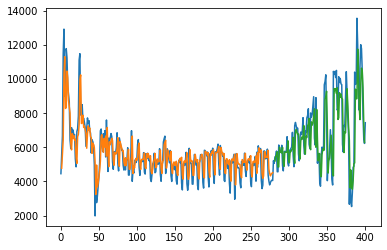

In [46]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()